In [7]:
# Cell 1: Imports & display options
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt

# nicer display in notebooks
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

In [8]:
# Cell 2: File path and load
# Update this path if your file is elsewhere.
user_path = r"/content/Online Retail.csv"

if os.path.exists(user_path):
    file_path = user_path
elif os.path.exists(alt_path):
    file_path = alt_path
else:
    raise FileNotFoundError(f"File not found at either:\n  {user_path}\n  {alt_path}\nUpdate the path and re-run.")

print("Loading from:", file_path)
df = pd.read_csv(file_path, encoding="ISO-8859-1")   # encoding often required for this dataset
print("Raw shape:", df.shape)

Loading from: /content/Online Retail.csv
Raw shape: (541909, 8)


In [9]:
# Cell 3: Explore basic info
print("Columns:", df.columns.tolist())
print("\nHEAD:")
display(df.head())

print("\nINFO:")
display(df.info())

print("\nNUMERIC DESCRIBE:")
display(df.describe(include=[np.number]).T)

# Missing values summary
missing_count = df.isnull().sum().sort_values(ascending=False)
missing_pct = (missing_count / len(df) * 100).round(2)
miss_df = pd.concat([missing_count, missing_pct], axis=1)
miss_df.columns = ["missing_count", "missing_pct"]
print("\nMissing values (non-zero only):")
display(miss_df[miss_df['missing_count'] > 0])

Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

HEAD:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 8:26,3.39,17850.0,United Kingdom



INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


None


NUMERIC DESCRIBE:


,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0



Missing values (non-zero only):


,missing_count,missing_pct
CustomerID,135080,24.93
Description,1454,0.27


In [10]:
# Cell 4: Clean column names and convert types
data = df.copy()
# strip whitespace in column names
data.columns = [c.strip() for c in data.columns]

# Convert InvoiceDate -> datetime (coerce bad values)
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], errors='coerce')

# Convert numeric columns
data['Quantity'] = pd.to_numeric(data['Quantity'], errors='coerce')
data['UnitPrice'] = pd.to_numeric(data['UnitPrice'], errors='coerce')

print("After conversions - nulls in InvoiceDate/Quantity/UnitPrice:")
display(data[['InvoiceDate','Quantity','UnitPrice']].isnull().sum())

After conversions - nulls in InvoiceDate/Quantity/UnitPrice:


,0
InvoiceDate,308950
Quantity,0
UnitPrice,0


In [11]:
# Cell 5: Remove rows missing essential information and duplicates
# Important fields: InvoiceNo, StockCode, InvoiceDate
before = data.shape[0]
data = data.dropna(subset=['InvoiceNo','StockCode','InvoiceDate'])
after_drop = data.shape[0]
print(f"Dropped {before - after_drop} rows missing essential fields.")

# Fill Description with placeholder (optional)
if 'Description' in data.columns:
    data['Description'] = data['Description'].fillna('Unknown')

# Remove exact duplicate rows
before_dup = data.shape[0]
data = data.drop_duplicates()
after_dup = data.shape[0]
print(f"Removed {before_dup - after_dup} exact duplicate rows. New shape: {data.shape}")

Dropped 308950 rows missing essential fields.
Removed 2303 exact duplicate rows. New shape: (230656, 8)


In [12]:
# Cell 6: Create Sales column and handle negative/return values
data['Sales'] = data['Quantity'] * data['UnitPrice']

# Flag rows that are returns or negative
data['is_return'] = (data['Quantity'] < 0) | (data['UnitPrice'] < 0) | (data['Sales'] < 0)

print("Total rows:", len(data))
print("Return rows flagged:", data['is_return'].sum(), "(", round(data['is_return'].sum()/len(data)*100,2), "% )")

# Split datasets for easier downstream analysis
returns_df = data[data['is_return']].copy()
cleaned_df = data[~data['is_return']].copy()

print("Cleaned (non-returns) shape:", cleaned_df.shape)
print("Returns shape:", returns_df.shape)

# Optionally, remove zero-quantity or zero-price rows from cleaned set (often meaningless)
cleaned_df = cleaned_df[(cleaned_df['Quantity'] > 0) & (cleaned_df['UnitPrice'] >= 0)]
print("Cleaned shape after enforcing Quantity>0 and UnitPrice>=0:", cleaned_df.shape)

Total rows: 230656
Return rows flagged: 4815 ( 2.09 % )
Cleaned (non-returns) shape: (225841, 10)
Returns shape: (4815, 10)
Cleaned shape after enforcing Quantity>0 and UnitPrice>=0: (225841, 10)


In [13]:
# Cell 7: Handling missing CustomerID (choose one approach)
print("Missing CustomerID in cleaned set:", cleaned_df['CustomerID'].isnull().sum())

# Option A: Keep them as NaN (useful if you want to treat anonymous customers separately)
# Option B: Drop rows missing CustomerID (useful for customer-level aggregations)
# Option C: Fill with a placeholder like 0 or -1 (not recommended for IDs unless you're explicit)

# Example: create a flag for missing CustomerID and keep rows
cleaned_df['CustomerID_missing'] = cleaned_df['CustomerID'].isnull()

# If you prefer to drop them uncomment the next line:
cleaned_df = cleaned_df.dropna(subset=['CustomerID'])

Missing CustomerID in cleaned set: 59460


In [14]:
# Cell 8: Feature engineering (datetime pieces, invoice aggregations)
df_fe = cleaned_df.copy()

# Datetime features
df_fe['InvoiceYear']  = df_fe['InvoiceDate'].dt.year
df_fe['InvoiceMonth'] = df_fe['InvoiceDate'].dt.month
df_fe['InvoiceDay']   = df_fe['InvoiceDate'].dt.day
df_fe['InvoiceHour']  = df_fe['InvoiceDate'].dt.hour
df_fe['InvoiceWeekday']= df_fe['InvoiceDate'].dt.weekday  # Monday=0

# Invoice-level aggregates
invoice_qty = df_fe.groupby('InvoiceNo')['Quantity'].sum().rename('TotalItemsPerInvoice')
invoice_sales = df_fe.groupby('InvoiceNo')['Sales'].sum().rename('TotalSalesPerInvoice')
invoice_unique_products = df_fe.groupby('InvoiceNo')['StockCode'].nunique().rename('UniqueProductsPerInvoice')

# Merge back to row-level (so each row has invoice totals)
df_fe = df_fe.merge(invoice_qty, left_on='InvoiceNo', right_index=True, how='left')
df_fe = df_fe.merge(invoice_sales, left_on='InvoiceNo', right_index=True, how='left')
df_fe = df_fe.merge(invoice_unique_products, left_on='InvoiceNo', right_index=True, how='left')

# Convert CustomerID to integer dtype where possible (pandas nullable Int)
df_fe['CustomerID'] = pd.to_numeric(df_fe['CustomerID'], errors='coerce').astype('Int64')

print("Feature engineered columns added. Sample:")
display(df_fe.head())

Feature engineered columns added. Sample:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,is_return,CustomerID_missing,InvoiceYear,InvoiceMonth,InvoiceDay,InvoiceHour,InvoiceWeekday,TotalItemsPerInvoice,TotalSalesPerInvoice,UniqueProductsPerInvoice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850,United Kingdom,15.30,False,False,2010,1,12,8,1,40,139.12,7
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34,False,False,2010,1,12,8,1,40,139.12,7
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850,United Kingdom,22.00,False,False,2010,1,12,8,1,40,139.12,7
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34,False,False,2010,1,12,8,1,40,139.12,7
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34,False,False,2010,1,12,8,1,40,139.12,7


In [15]:
# Cell 9: Encode categorical variables
df_enc = df_fe.copy()

# Country: reduce to top N categories and mark rest as 'Other' then one-hot encode
top_n = 10
top_countries = df_enc['Country'].value_counts().head(top_n).index.tolist()
df_enc['Country_reduced'] = df_enc['Country'].where(df_enc['Country'].isin(top_countries), other='Other')
country_dummies = pd.get_dummies(df_enc['Country_reduced'], prefix='Country', drop_first=False)
df_enc = pd.concat([df_enc, country_dummies], axis=1)

# StockCode: label encode (useful as an ID; for modeling prefer frequency/target encoding)
le_sc = LabelEncoder()
df_enc['StockCode_le'] = le_sc.fit_transform(df_enc['StockCode'].astype(str))

print("Encoded country (one-hot) and label-encoded StockCode. Columns example:")
print([c for c in df_enc.columns if c.startswith('Country_')][:10] + ['StockCode_le'])
display(df_enc.head())

Encoded country (one-hot) and label-encoded StockCode. Columns example:
['Country_reduced', 'Country_Belgium', 'Country_EIRE', 'Country_France', 'Country_Germany', 'Country_Netherlands', 'Country_Norway', 'Country_Other', 'Country_Portugal', 'Country_Spain', 'StockCode_le']


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,is_return,CustomerID_missing,InvoiceYear,InvoiceMonth,InvoiceDay,InvoiceHour,InvoiceWeekday,TotalItemsPerInvoice,TotalSalesPerInvoice,UniqueProductsPerInvoice,Country_reduced,Country_Belgium,Country_EIRE,Country_France,Country_Germany,Country_Netherlands,Country_Norway,Country_Other,Country_Portugal,Country_Spain,Country_Switzerland,Country_United Kingdom,StockCode_le
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850,United Kingdom,15.30,False,False,2010,1,12,8,1,40,139.12,7,United Kingdom,False,False,False,False,False,False,False,False,False,False,True,3150
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34,False,False,2010,1,12,8,1,40,139.12,7,United Kingdom,False,False,False,False,False,False,False,False,False,False,True,2600
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850,United Kingdom,22.00,False,False,2010,1,12,8,1,40,139.12,7,United Kingdom,False,False,False,False,False,False,False,False,False,False,True,2788
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34,False,False,2010,1,12,8,1,40,139.12,7,United Kingdom,False,False,False,False,False,False,False,False,False,False,True,2743
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34,False,False,2010,1,12,8,1,40,139.12,7,United Kingdom,False,False,False,False,False,False,False,False,False,False,True,2742


In [16]:
# Cell 10: Scaling numeric features (standard + min-max)
num_cols = ['Quantity','UnitPrice','Sales','TotalItemsPerInvoice','TotalSalesPerInvoice','UniqueProductsPerInvoice']
# ensure no NaNs in scaling
df_enc[num_cols] = df_enc[num_cols].fillna(0)

scaler_std = StandardScaler()
scaler_mm  = MinMaxScaler()

# Standard scaled
df_enc[[c + '_std' for c in num_cols]] = scaler_std.fit_transform(df_enc[num_cols])
# Min-Max scaled
df_enc[[c + '_mm' for c in num_cols]] = scaler_mm.fit_transform(df_enc[num_cols])

print("Added scaled columns. Sample:")
display(df_enc[[*num_cols, *(c + '_std' for c in num_cols), *(c + '_mm' for c in num_cols)]].head())

Added scaled columns. Sample:


,Quantity,UnitPrice,Sales,TotalItemsPerInvoice,TotalSalesPerInvoice,UniqueProductsPerInvoice,Quantity_std,UnitPrice_std,Sales_std,TotalItemsPerInvoice_std,TotalSalesPerInvoice_std,UniqueProductsPerInvoice_std,Quantity_mm,UnitPrice_mm,Sales_mm,TotalItemsPerInvoice_mm,TotalSalesPerInvoice_mm,UniqueProductsPerInvoice_mm
0,6,2.55,15.30,40,139.12,7,-0.035541,-0.023101,-0.018420,-0.450051,-0.416583,-0.773896,0.000062,0.000313,0.000091,0.000482,0.000826,0.01145
1,6,3.39,20.34,40,139.12,7,-0.035541,0.008838,-0.006717,-0.450051,-0.416583,-0.773896,0.000062,0.000416,0.000121,0.000482,0.000826,0.01145
2,8,2.75,22.00,40,139.12,7,-0.025699,-0.015496,-0.002862,-0.450051,-0.416583,-0.773896,0.000086,0.000338,0.000131,0.000482,0.000826,0.01145
3,6,3.39,20.34,40,139.12,7,-0.035541,0.008838,-0.006717,-0.450051,-0.416583,-0.773896,0.000062,0.000416,0.000121,0.000482,0.000826,0.01145
4,6,3.39,20.34,40,139.12,7,-0.035541,0.008838,-0.006717,-0.450051,-0.416583,-0.773896,0.000062,0.000416,0.000121,0.000482,0.000826,0.01145


In [17]:
# Cell 11: Correlation (helpful for quick feature selection)
numeric_for_corr = df_enc.select_dtypes(include=[np.number]).copy()
corr = numeric_for_corr.corr()
sales_corr = corr['Sales'].drop('Sales').abs().sort_values(ascending=False)
print("Top correlations with Sales:")
display(sales_corr.head(20))

Top correlations with Sales:


,Sales
Sales_std,1.000000
Sales_mm,1.000000
Quantity,0.961294
Quantity_mm,0.961294
Quantity_std,0.961294
TotalSalesPerInvoice,0.350587
TotalSalesPerInvoice_std,0.350587
TotalSalesPerInvoice_mm,0.350587
TotalItemsPerInvoice_mm,0.265093
TotalItemsPerInvoice,0.265093


In [18]:
# Cell 12: Save outputs
out_dir = os.path.join(os.getcwd(), "cleaned_output")
os.makedirs(out_dir, exist_ok=True)

cleaned_out = os.path.join(out_dir, "online_retail_cleaned.csv")
returns_out = os.path.join(out_dir, "online_retail_returns.csv")

df_enc.to_csv(cleaned_out, index=False)
returns_df.to_csv(returns_out, index=False)

print("Saved cleaned dataset to:", cleaned_out)
print("Saved returns dataset to:", returns_out)

Saved cleaned dataset to: /content/cleaned_output/online_retail_cleaned.csv
Saved returns dataset to: /content/cleaned_output/online_retail_returns.csv


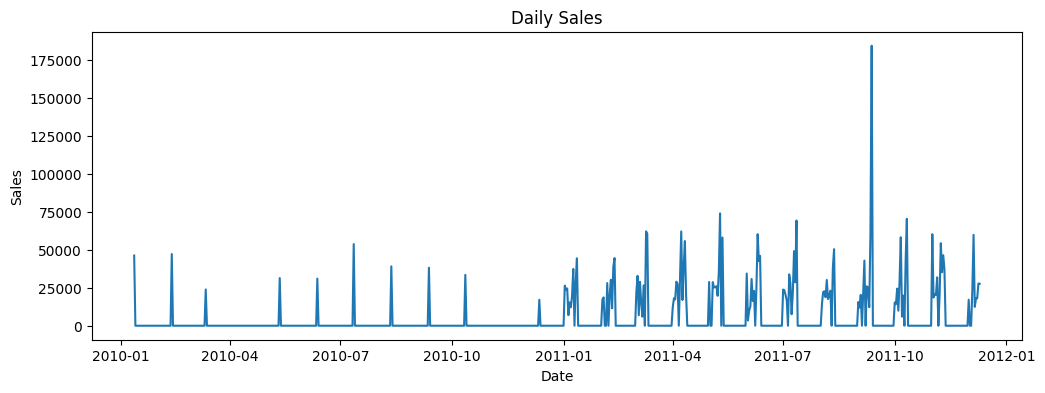

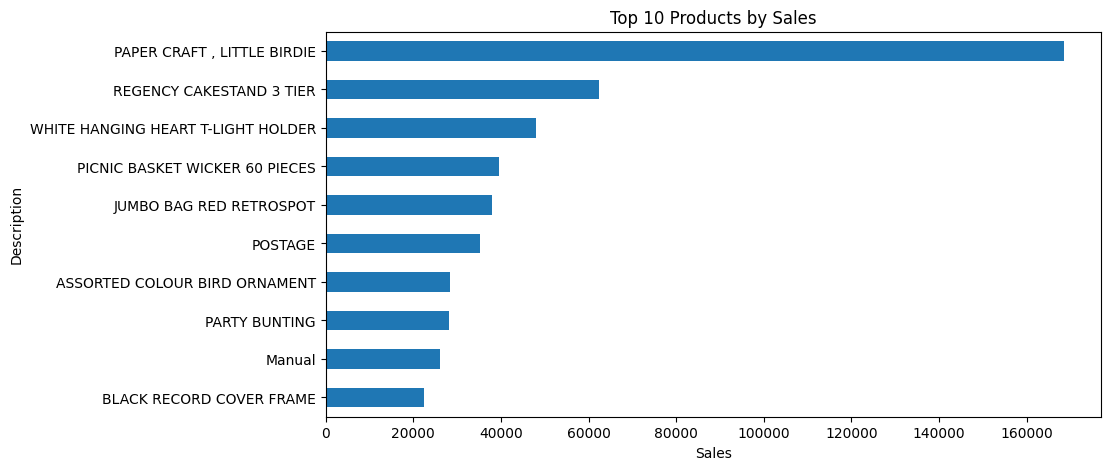

In [19]:
# Cell 13: A few basic plots (optional)
import matplotlib.pyplot as plt

# 1) Sales over time (by day)
daily = df_enc.set_index('InvoiceDate').resample('D')['Sales'].sum().fillna(0)
plt.figure(figsize=(12,4))
plt.plot(daily.index, daily.values)
plt.title("Daily Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

# 2) Top 10 products by total sales
top_products = df_enc.groupby('Description')['Sales'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
top_products[::-1].plot(kind='barh')
plt.title("Top 10 Products by Sales")
plt.xlabel("Sales")
plt.show()